# Wind Farm Power Prediction

In [1]:
from floris.floris import Floris
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import GPy
import random
import time
from visualization_manager import VisualizationManager
from pygmo import hypervolume
from mpl_toolkits.mplot3d import Axes3D

# Visualization
from copy import deepcopy
from pareto import Pareto
from scipy.optimize import minimize
from scipy.stats import norm
from pareto import Pareto
from BayesianOpt import *
%matplotlib inline

# Define Wind Farm Power Calculator
## inputs are:
floris object (that will be initiated with wind farm configuations, i.e., number of WT, locations)

wd (wind direction)

ws (wind speed)

yawAngle (action vector whose dimension is the number of wind turbines) 

In [2]:
def windFarmPower(floris,wd, ws, yawAngle,scale):
    
    #set up wind direction and speed
    floris.farm.flow_field.wind_direction = np.radians(wd - 270) # frame of reference is west
    floris.farm.flow_field.wind_speed = ws
    floris.farm.flow_field.initial_flowfield = floris.farm.flow_field._initial_flowfield()
    floris.farm.flow_field.u_field = floris.farm.flow_field._initial_flowfield()
    
    
    turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
    for k,turbine in enumerate(turbines):
        turbine.yaw_angle = np.radians(yawAngle[k])
    floris.farm.flow_field.calculate_wake()
    
    power = np.zeros([len(yawAngle),1])
    totalPower = 0.0
    for i, turbine in enumerate(turbines):
        power[i]=turbine.power
        totalPower = totalPower + turbine.power    
    
    return power/scale, totalPower/scale/len(turbines)

# Compute the maximum wind turbine power using single wind turbine 

In [3]:
#run wind farm configuration input with a single wind turbine
floris = Floris("example_input_single.json")
numWT = 1
scale = 1.0
#conventional default input is yawAngle = 0 degree
yawAngle0 = np.zeros(numWT)

#compute the wind turbine power vector and total wind farm power (for single wind turbine they are the same)
powerSingle,totalPower = windFarmPower(floris,0, 8, yawAngle0,scale)

for coord, turbine in floris.farm.turbine_map.items():
    print(str(coord) + ":")
    print("\tCp -", turbine.Cp)
    print("\tCt -", turbine.Ct)
    print("\tpower -", turbine.power)
    print("\tai -", turbine.aI)
    print("\taverage velocity -", turbine.get_average_velocity())

(0.0, 0.0):
	Cp - 0.46328782548262326
	Ct - 0.7661304442831962
	power - 1712005.1679717556
	ai - 0.2581996920407235
	average velocity - 7.85065163365446


## Setup Wind Farm Layout
### Open "example_input_double.json" and look at how the wind farm is defined

In [4]:
floris = Floris("example_input_double.json")

# Compute the power vector and total wind farm power

In [5]:
wd=180;
ws=8;
num_tur = len(floris.farm.flow_field.turbine_map.items())
yawAngle = np.ones(num_tur)*0.01
power, totalPower = windFarmPower(floris, wd, 8, yawAngle, powerSingle)
totalPower

array([[0.99999909]])

# Compare the greedy control and cooperative control (optimized yaw angle vector)

In [6]:
def multiobj_f(yawangle):
    Y1 = np.zeros(len(yawangle))[:,None]
    Y2 = np.zeros(len(yawangle))[:,None]
    for i,angle in enumerate(yawangle):
        power,totalPower = windFarmPower(floris, angle[-1], 8, angle[:-1], powerSingle)
        Y1[i] = -totalPower
        Y2[i] = np.sum(np.square(np.radians(angle[:-1]))) / np.square(np.radians(25.0)) / num_tur
    Y = np.hstack((Y1,Y2))
    return Y

In [7]:
minimum_yaw_angle = 0.0
maximum_yaw_angle = 25.0

bounds = np.zeros((num_tur, 2))
for i in range(num_tur):
    bounds[i,:] = [minimum_yaw_angle, maximum_yaw_angle]
    
# number of turbines + wind context
n_params = bounds.shape[0]+1

In [8]:
def generate_context(lower, upper, length, test_c):
    con = [test_c]
    for i in range(length-1):
        add = np.random.normal(0,2)
        if con[-1] + add > upper or con[-1] + add < lower:
                new_c = con[-1] - add  
        else:
            new_c = con[-1] + add  
        con.append(new_c)
    return np.array(con)[:,None]

In [9]:
# initial data point of wind-farm
init_sample = 1
wd_init = np.random.uniform(90, 120, size=(init_sample, 1))

X = np.zeros((init_sample, bounds.shape[0]))
for i, yawangles in enumerate(np.random.uniform(bounds[:, 0], bounds[:, 1], (init_sample, bounds.shape[0]))):
    X[i,:] = yawangles
X = np.hstack((X, wd_init))
Y = multiobj_f(X)

In [10]:
num_output = Y.shape[1]
num_iter = 3000
wd_context = generate_context(90, 120, num_iter, wd_init[0][0])
t1 = time.time()
    
for i in range(num_iter):
    print(i)
    pareto = Pareto(np.empty((0, num_output)))
    reference = np.ones((1, num_output))

    if i == 0:
        gp_models = [GPy.models.GPRegression(X.copy(), Y[:,[i]].copy(), kernel= GPy.kern.Matern52(input_dim=n_params, ARD=True)) for i in range(Y.shape[1])]
    elif i%10 != 0:
        gp_models = [GPy.models.GPRegression(X.copy(), Y[:,[i]].copy(), kernel= gp_models[i].kern, noise_var = gp_models[i].likelihood[0] ) for i in range(Y.shape[1])]
    else:
        gp_models = [GPy.models.GPRegression(X.copy(), Y[:,[i]].copy(), kernel= gp_models[i].kern, noise_var = gp_models[i].likelihood[0] ) for i in range(Y.shape[1])]
        for m in gp_models:
            m.optimize()
    
    trusted_X = np.array([X[j] for j in range(len(X)) if wd_context[i]-30 <= X[j,-1] <= wd_context[i]+30])
    context_X = np.hstack((trusted_X[:,:-1], np.ones((len(trusted_X), 1)) * wd_context[i]))    
    preds =  [m.predict(context_X) for m in gp_models]
    context_Y, var = (np.concatenate(moment, 1) for moment in zip(*preds))
    
    pareto.update(context_Y)
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
       
    next_point = np.atleast_2d(sample_next_point(hypervolume_poi, gp_models, bounds, pareto, reference, num_output, wd_context[i]))
    next_point = np.hstack((next_point, np.ones((1,1)) * wd_context[i]))
    X = np.append(X, next_point, axis = 0)
    function_value = multiobj_f(np.atleast_2d(next_point))
    Y = np.append(Y, function_value, axis = 0)
t2 = time.time()
print(t2-t1)

0
1
2
3
4
5
6
7
8
9
10


 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


11
12
13
14
15
16
17
18
19
20


 /home/cwj/venv/local/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220


 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:invalid value encountered in true_divide


221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470


 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:invalid value encountered in subtract


1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990


In [11]:
Y = Y[1:]

In [12]:
# Approximated Pareto set
x_coord = np.arange(0,25,0.5)
x1, x2 = np.meshgrid(x_coord, x_coord)
x = np.hstack((x1.ravel()[:,None],x2.ravel()[:,None]))
cont = np.ones((len(x),1))
for c in np.arange(90,120.5,0.5):
    pareto = Pareto(np.empty((0, num_tur)))
    if c == 90:
        C = cont * c
        xx = np.hstack((x, C))
        f1 = multiobj_f(xx)[:,0][:,None]
        f2 = multiobj_f(xx)[:,1][:,None]
        pareto.update(multiobj_f(xx))
        pareto_f1 = pareto.front[:,0][:,None]
        pareto_f2 = pareto.front[:,1][:,None]
        pareto_C = np.ones((len(pareto.front),1)) * c
    else:
        C = np.append(C, cont * c, axis = 0)
        xx = np.hstack((x, cont * c))
        f1 = np.append(f1, multiobj_f(xx)[:,0][:,None], axis = 0)
        f2 = np.append(f2, multiobj_f(xx)[:,1][:,None], axis = 0)
        pareto.update(multiobj_f(xx))
        pareto_f1 = np.append(pareto_f1, pareto.front[:,0][:,None], axis = 0)
        pareto_f2 = np.append(pareto_f2, pareto.front[:,1][:,None], axis = 0)
        pareto_C = np.append(pareto_C, np.ones((len(pareto.front),1)) * c, axis = 0)
print(len(C))
len(pareto_f1)

152500


1451

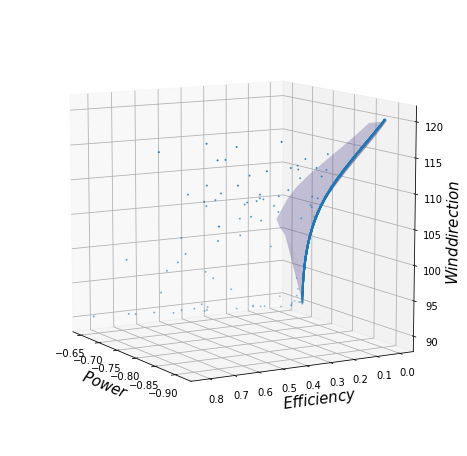

In [19]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


# Plot the surface
ax.plot_trisurf(pareto_f1.flatten(), pareto_f2.flatten(), pareto_C.flatten(), color='slateblue', alpha = 0.3)
ax.scatter(Y[:,0], Y[:,1], wd_context, s=1, label = 'Selected pts')
ax.view_init(azim=150, elev=10)
ax.set_xlabel('$Power$', fontsize=15, rotation=1450)
ax.set_ylabel('$Efficiency$', fontsize=15)
ax.set_zlabel('$Wind direction$', fontsize=15)
plt.show()
# plt.savefig('pareto_surface.png')

In [16]:
pareto_C.flatten()

array([ 90. ,  90.5,  90.5, ..., 120. , 120. , 120. ])

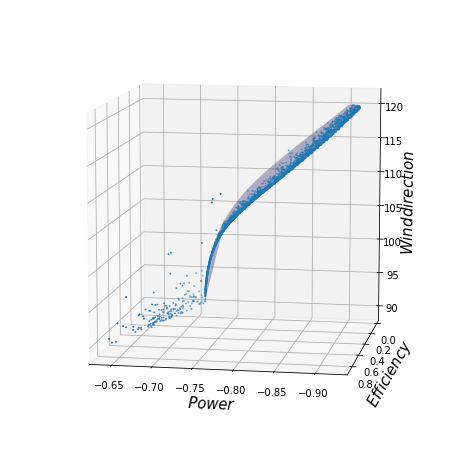

<Figure size 432x288 with 0 Axes>

In [241]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


# Plot the surface
ax.plot_trisurf(pareto_f1.flatten(), pareto_f2.flatten(), pareto_C.flatten(), color='slateblue', alpha = 0.4)
ax.scatter(Y[:,0], Y[:,1], wd, s=1, label = 'Selected pts')
ax.view_init(azim=100, elev=10)
ax.set_xlabel('$Power$', fontsize=15, rotation=150)
ax.set_ylabel('$Efficiency$', fontsize=15)
ax.set_zlabel('$Wind direction$', fontsize=15)
plt.show()
plt.savefig('pareto_surface.png')

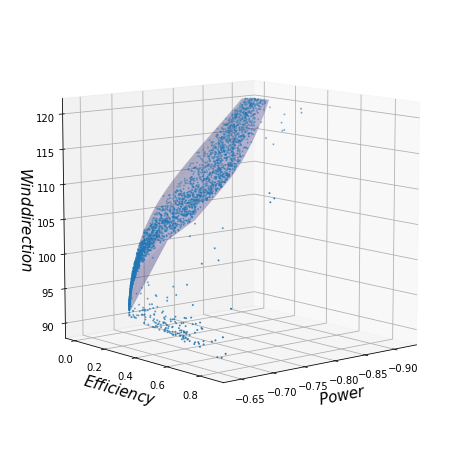

<Figure size 432x288 with 0 Axes>

In [245]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


# Plot the surface
ax.plot_trisurf(pareto_f1.flatten(), pareto_f2.flatten(), pareto_C.flatten(), color='slateblue', alpha = 0.4)
ax.scatter(Y[:,0], Y[:,1], wd, s=1, label = 'Selected pts')
ax.view_init(azim=50, elev=10)
ax.set_xlabel('$Power$', fontsize=15, rotation=150)
ax.set_ylabel('$Efficiency$', fontsize=15)
ax.set_zlabel('$Wind direction$', fontsize=15)
plt.show()
plt.savefig('pareto_surface.png')

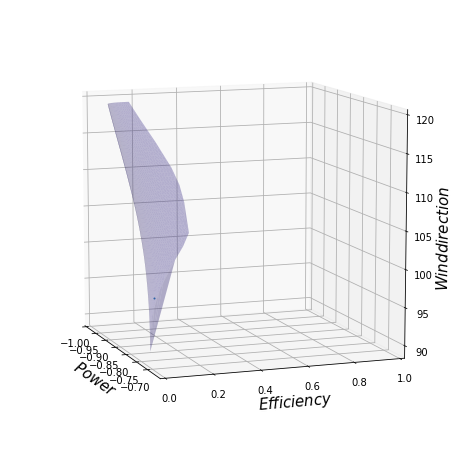

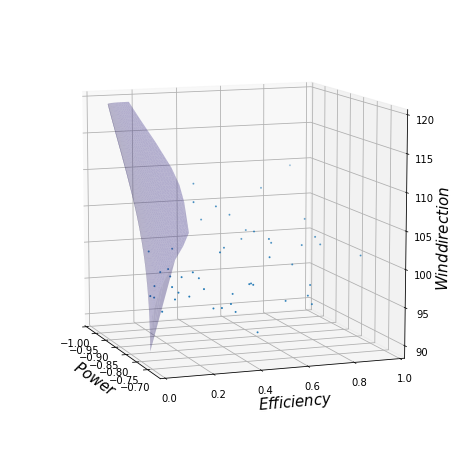

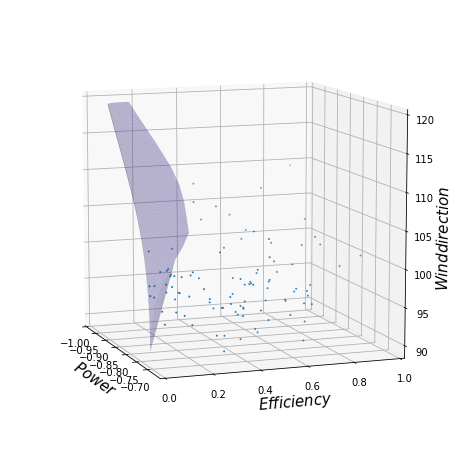

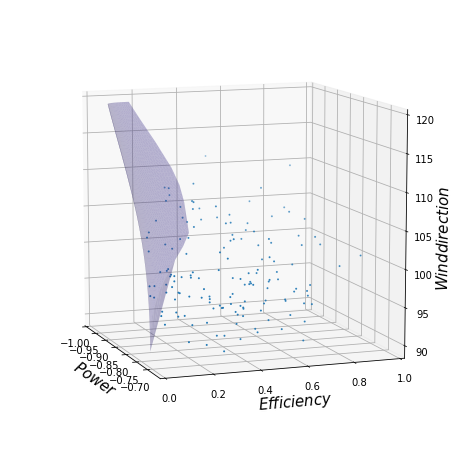

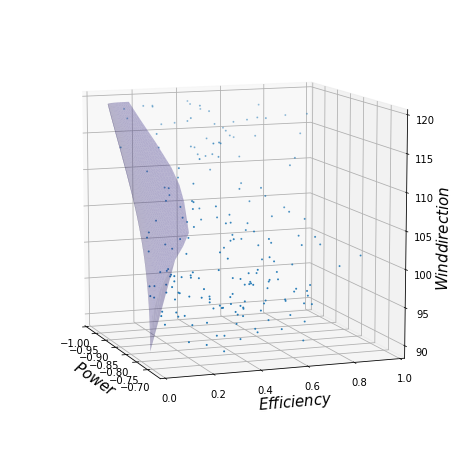

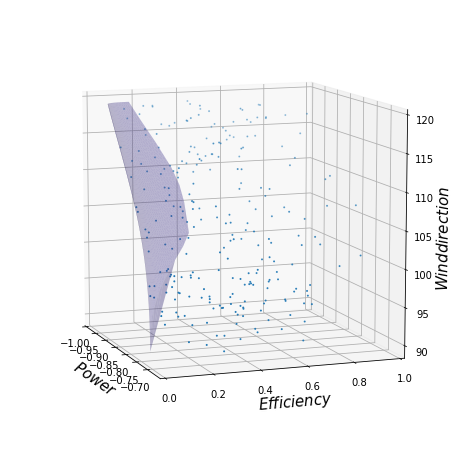

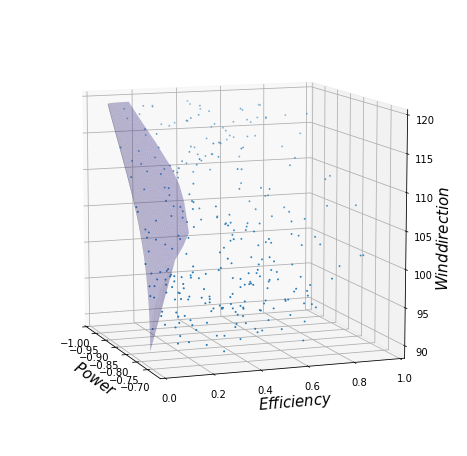

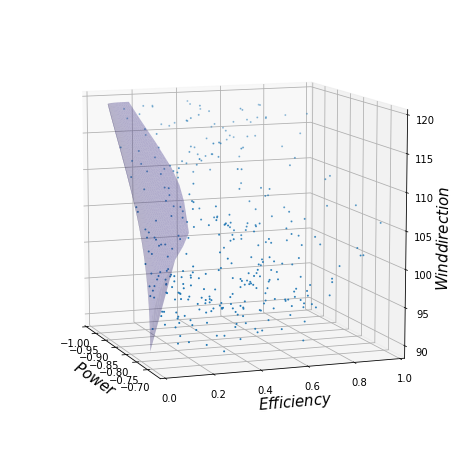

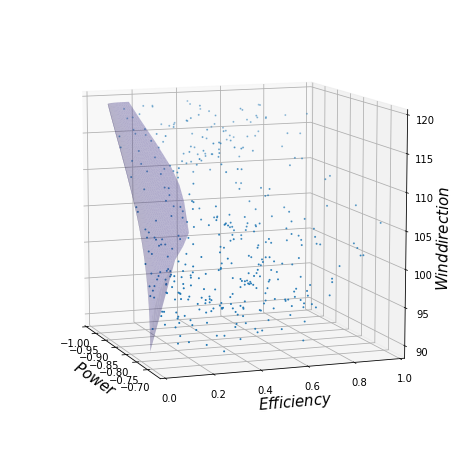

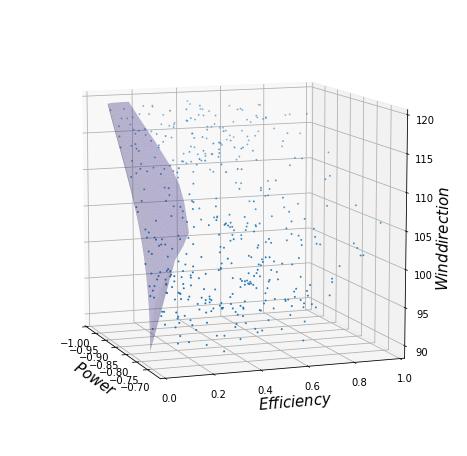

KeyboardInterrupt: 

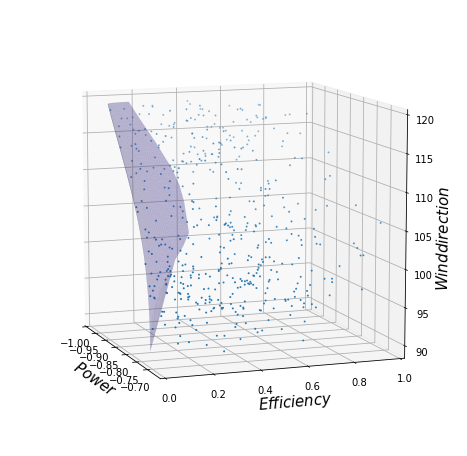

In [29]:
for i in range(0,3000,50):
    # Plot the surface
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(pareto_f1.flatten(), pareto_f2.flatten(), pareto_C.flatten(), color='slateblue', alpha = 0.4)
    ax.scatter(Y[:i+1,0], Y[:i+1,1], wd_context[:i+1], s=1, label = 'Selected pts')
    ax.view_init(azim=340, elev=10)
    ax.set_xlabel('$Power$', fontsize=15, rotation=150)
    ax.set_ylabel('$Efficiency$', fontsize=15)
    ax.set_zlabel('$Wind direction$', fontsize=15)
    ax.set_xlim([-1,-0.65])
    ax.set_ylim([0,1])
    ax.set_zlim([89,120])
    plt.savefig(str(i)+'png')
    plt.show()
   

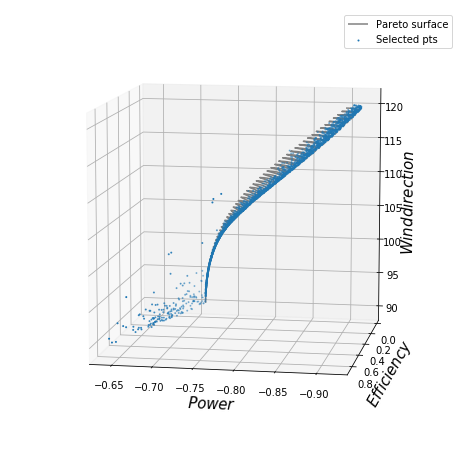

<Figure size 432x288 with 0 Axes>

In [218]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(pareto_f1, pareto_f2, pareto_C, color='gray', label = 'Pareto surface')
ax.scatter(Y[:,0], Y[:,1], wd, s=1, label = 'Selected pts')
ax.view_init(azim=100, elev=10)
ax.set_xlabel('$Power$', fontsize=15, rotation=150)
ax.set_ylabel('$Efficiency$', fontsize=15)
ax.set_zlabel('$Wind direction$', fontsize=15)
ax.legend()
plt.show()
plt.savefig('surface2.png')
plt.show()